<a href="https://colab.research.google.com/github/masadeghi/dementia_clf_fmri/blob/main/experiments/analysis_scripts/fmri_dementia_rocket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, balanced_accuracy_score

!pip install -qU focal_loss_torch
from focal_loss.focal_loss import FocalLoss

!pip install -qU tsai
from tsai.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.7 MB/s eta 0:00:00


In [ ]:
my_setup()

os              : Linux-5.10.147+-x86_64-with-glibc2.29
python          : 3.8.10
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.1+cu116
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : N/A


# Import data

In [ ]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia"

labels = pd.read_csv(os.path.join(data_path, 'labels_new.csv'))

# Train/val/test split

In [ ]:
# Splitting out the test set
labels_train_val, labels_test = train_test_split(labels, test_size = 0.1,
                                            shuffle = True, random_state = 42,
                                            stratify = labels['label'])

# Train/val split
labels_train, labels_val = train_test_split(labels_train_val, test_size = 0.2,
                                            shuffle = True, random_state = 42,
                                            stratify = labels_train_val['label'])

In [ ]:
labels_train_val = labels_train_val.reset_index()
labels_train = labels_train.reset_index()
labels_val = labels_val.reset_index()
labels_test = labels_test.reset_index()

In [ ]:
# labels_train_val.to_csv(os.path.join(data_path, 'labels_train_val.csv'), header = True)
# labels_test.to_csv(os.path.join(data_path, 'labels_test.csv'), header = True)
# labels_train.to_csv(os.path.join(data_path, 'labels_train.csv'), header = True)
# labels_val.to_csv(os.path.join(data_path, 'labels_val.csv'), header = True)

# Create datasets

In [ ]:
def get_datasets(data_csv):

  X = np.empty((len(data_csv), 200, 140))
  y = np.empty(len(data_csv))

  for i, row in data_csv.iterrows():
    matrix_name = row['matrix']
    matrix_label = row['label']
    matrix_path = os.path.join(data_path, 'data_dir', matrix_name)
    matrix_arr = np.genfromtxt(matrix_path, delimiter = ',')
    matrix_arr = matrix_arr[:200, :140]
    X[i] = matrix_arr
    y[i] = matrix_label

  return X, y

In [ ]:
X, y = get_datasets(labels_train_val)
X_train, y_train = get_datasets(labels_train)
X_val, y_val = get_datasets(labels_val)
X_test, y_test = get_datasets(labels_test)

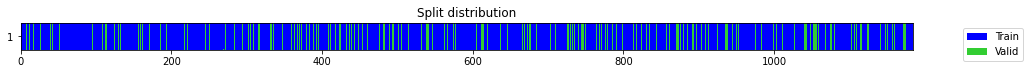

In [ ]:
# If training train/val sets together:
splits = get_splits(y, valid_size = .2, stratify = True, random_state = 42, shuffle = True)

In [ ]:
class_map = {
    1: 'AD',
    2: 'FTD',
    3: 'HC',
    4: 'MCI'
}

labeler = ReLabeler(class_map)
y = labeler(y)
y_train = labeler(y_train)
y_val = labeler(y_val)
y_test = labeler(y_test)

# Generate features

In [ ]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits = splits,
                 tfms = tfms, drop_last = False,
                 shuffle_train = False, batch_tfms = batch_tfms,
                 bs=10_000)

In [ ]:
model = build_ts_model(ROCKET, dls=dls)

In [ ]:
X_train_rocket, y_train_rocket = create_rocket_features(dls.train, model)
X_valid_rocket, y_valid_rocket = create_rocket_features(dls.valid, model)
X_train_rocket.shape, X_valid_rocket.shape

((948, 20000), (237, 20000))

# Classify features

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
ridge = RidgeClassifierCV(alphas = np.logspace(-8, 8, 17), normalize=True)
ridge.fit(X_train_rocket, y_train_rocket)
print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train_rocket, y_train_rocket):.5f}  valid: {ridge.score(X_valid_rocket, y_valid_rocket):.5f}')

alpha: 1.00E+01  train: 0.98840  valid: 0.63291
